In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import random

/home/borowis/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
bs,bptt = 32,70

# Prepare data for fast.ai

In [3]:
PATH = "/home/borowis/s3/data/"

In [4]:
!ls -al {PATH}

total 575036
drwxr-xr-x 5 borowis borowis      4096 Oct 24 20:34 .
drwxr-xr-x 4 borowis borowis      4096 Oct 24 20:25 ..
drwxr-xr-x 7 borowis borowis      4096 Oct 24 21:17 all
drwxr-xr-x 4 borowis borowis      4096 Oct 24 20:34 bugs
-rw-r--r-- 1 borowis borowis   1818381 Sep 29 15:45 bugs-local-ground-truth.csv
-rw-r--r-- 1 borowis borowis  24808206 Sep 29 15:45 bugs-local-testing.csv
-rw-r--r-- 1 borowis borowis  20089763 Sep 29 15:45 bugs-testing.csv
-rw-r--r-- 1 borowis borowis  59836175 Sep 29 15:45 bugs-training.csv
-rw-r--r-- 1 borowis borowis       601 Sep 25 20:58 classifications.csv
-rw-r--r-- 1 borowis borowis    274985 Sep 29 15:42 components.csv
-rw-r--r-- 1 borowis borowis 473785984 Sep 26 21:50 longdescs.csv
drwxr-xr-x 2 borowis borowis      4096 Oct 24 21:13 models
-rw-r--r-- 1 borowis borowis     25154 Sep 25 21:00 products.csv
-rw-r--r-- 1 borowis borowis   8089305 Oct  2 19:34 profiles.csv
-rw-r--r-- 1 borowis borowis     64987 Sep 25 20:59 versions.csv


In [5]:
df_components = pd.read_csv(PATH + 'components.csv')

In [7]:
df_bugs_training = pd.read_csv(PATH + 'bugs-training.csv')
df_bugs_testing = pd.read_csv(PATH + 'bugs-testing.csv')

In [8]:
df_description = pd.read_csv(PATH + 'longdescs.csv')

In [9]:
df_components.head()

,name,description,product_id,id,isactive,scoring_weight
0,Build Config,For bugs that result from SeaMonkey build prob...,25,3,1,0.25
1,GFX,Cross platform rendering interfaces and cross ...,49,4,1,0.25
2,Networking: Cookies,A general mechanism which server side connecti...,1,5,1,1.00
3,DOM: Core & HTML,This component includes all functionality rela...,1,6,1,1.00
4,DOM,"For bugs in <a href=""http://www.w3.org/DOM/"" t...",1,7,1,1.00


In [10]:
df_bugs_training.head()

,bug_id,short_desc,creation_ts,reporter,rep_platform,op_sys,assigned_to,version,component_id
0,771351,disallow plugins in popup panels gracefully,2012-07-06 00:03:43,255010,All,All,255010,Trunk,299
1,771352,turn off iframe features ala browserid sandbox,2012-07-06 00:06:46,436630,x86,Mac OS X,1,unspecified,1453
2,771353,Security documentation for Social Integration ...,2012-07-06 00:07:51,436630,x86,Mac OS X,1,unspecified,1453
3,771354,Loading remote xul crashes gecko,2012-07-06 00:08:04,418814,All,All,313730,Trunk,132
4,771355,[Fx14] l10n Android Mobile What's New Page,2012-07-06 00:09:45,387900,x86,Mac OS X,24572,unspecified,1526


In [11]:
df_bugs_testing.head()

,bug_id,short_desc,creation_ts,reporter,rep_platform,op_sys
0,1425503,Float first-letter negative margin-bottom (dro...,2017-12-15 19:03:51,571010,Unspecified,Unspecified
1,1338432,t-w864-ix-086 problem tracking,2017-02-10 05:54:44,135518,x86_64,Windows 8
2,1325240,Failure in conformance2/programs/gl-get-frag-d...,2016-12-22 01:40:07,419431,Unspecified,Unspecified
3,1350050,Remove a bunch of unnecessary casts in Content...,2017-03-23 20:43:34,546716,Unspecified,Unspecified
4,1399712,Frequent Windows 10 reftest/crashtest/jsreftes...,2017-09-14 05:50:54,135518,x86_64,Windows 10


In [12]:
df_description.head()

,bug_id,long_desc
0,771351,NaN
1,771352,The security review identified the importance ...
2,771353,The security review identified the importance ...
3,771354,We load some remote xul for Marionette unit te...
4,771355,Pascal - Can you help l10n this video subtitle...


In [13]:
df_bugs_training_desc = df_bugs_training.merge(df_description, how='left', on=['bug_id'])
df_bugs_testing_desc = df_bugs_testing.merge(df_description, how='left', on=['bug_id'])
df_bugs_training_desc[['short_desc', 'long_desc']] = df_bugs_training_desc[['short_desc', 'long_desc']].astype(str)
df_bugs_testing_desc[['short_desc', 'long_desc']] = df_bugs_testing_desc[['short_desc', 'long_desc']].astype(str)

In [14]:
df_bugs_training_desc.head()

,bug_id,short_desc,creation_ts,reporter,rep_platform,op_sys,assigned_to,version,component_id,long_desc
0,771351,disallow plugins in popup panels gracefully,2012-07-06 00:03:43,255010,All,All,255010,Trunk,299,nan
1,771352,turn off iframe features ala browserid sandbox,2012-07-06 00:06:46,436630,x86,Mac OS X,1,unspecified,1453,The security review identified the importance ...
2,771353,Security documentation for Social Integration ...,2012-07-06 00:07:51,436630,x86,Mac OS X,1,unspecified,1453,The security review identified the importance ...
3,771354,Loading remote xul crashes gecko,2012-07-06 00:08:04,418814,All,All,313730,Trunk,132,We load some remote xul for Marionette unit te...
4,771355,[Fx14] l10n Android Mobile What's New Page,2012-07-06 00:09:45,387900,x86,Mac OS X,24572,unspecified,1526,Pascal - Can you help l10n this video subtitle...


## Create folders and write files

In [21]:
os.makedirs(f'{PATH}all/trn', exist_ok=True)
os.makedirs(f'{PATH}all/val', exist_ok=True)
os.makedirs(f'{PATH}all/test', exist_ok=True)
os.makedirs(f'{PATH}models', exist_ok=True)

In [22]:
for _, r in df_components.iterrows():
    os.makedirs(f'{PATH}bugs/trn/' + str(r['id']), exist_ok=True)
    os.makedirs(f'{PATH}bugs/val/' + str(r['id']), exist_ok=True)

In [23]:
for _, r in df_bugs_training_desc.iterrows():
    dset = 'trn' if random.random() > 0.1 else 'val'
    bug_id = str(r['bug_id'])
    component_id = str(r['component_id'])
    open(f'{PATH}all/{dset}/{bug_id}.txt', 'w').write(r['short_desc'] + ' ' + r['long_desc'])
    open(f'{PATH}bugs/{dset}/{component_id}/{bug_id}.txt', 'w') \
        .write(r['short_desc'] + ' ' + r['long_desc'])

In [24]:
for _, r in df_bugs_testing_desc.iterrows():
    bug_id = str(r['bug_id'])
    open(f'{PATH}all/test/{bug_id}.txt', 'w').write(r['short_desc'] + ' ' + r['long_desc'])

## Language modeling

In [4]:
spacy_tok = spacy.load('en')

In [5]:
TEXT = data.Field(lower=True, tokenize='spacy')
FILES = dict(train='trn', validation='val', test='test')

In [7]:
md = LanguageModelData.from_text_files(f'{PATH}all/', TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [6]:
#pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [8]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(24335, 162041, 1, 54513350)

In [17]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '/', ':', '-', 'the', '.', ',', '=', ')', 'to', '"']

In [18]:
' '.join(md.trn_ds[0].text[:150])

'file bugs for new integration tests https://github.com/mozilla/webmaker-tests has a good set of integration tests for webmaker.org . but the webqa community needs more to work on ! so this bug ... is about filing more bugs . <eos> mozactivity - new email - does n\'t get " body " passing " body " to the mozactivity results in " undefined " in the email compose window . <eos> possible bug in end_to_end_reconfig.sh when using -p option ? from : simone bruno < simone@mozilla.com > subject : maybe a bug in your end_to_end_reconfig script date : thu , 5 jun 2014 21:12:47 + 0200 to : peter moore < pmoore@mozilla.com > hey pete , you know yesterday i run a reconfig using your script . today i run a dry - run reconfig ( -p ) option , and the list of changes which would have been brought live partially overlapped'

### Train

In [9]:
em_sz = 200
nh = 500
nl = 3
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [12]:
drops = np.array([0.1, 0.15, 0.25, 0.02, 0.2])*0.9
# 0.07 0.105 0.175 0.014 0.14 
# 0.08 0.12  0.2   0.016 0.16
# 0.09 0.135 0.225 0.018 0.18

In [13]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
    dropout=drops[0], dropouth=drops[1], dropouti=drops[2], dropoute=drops[3], wdrop=drops[4])
#    dropout=0.05, dropouth=0.1, dropouti=0.05, dropoute=0.02, wdrop=0.2)
# dropout=0.4, dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5
#                dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [14]:
learner.lr_find()

 69%|██████▊   | 16689/24335 [38:37<18:17,  6.97it/s, loss=15.9, refresh=0]

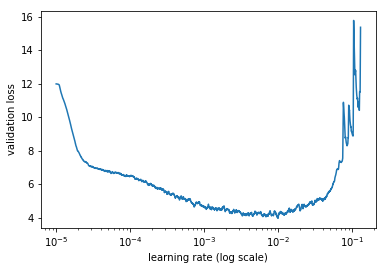

In [15]:
learner.sched.plot()

In [16]:
learner.fit(3e-3, 1, wds=1e-6)

  0%|          | 47/24335 [00:06<52:36,  7.70it/s, loss=7.37, refresh=0]   
epoch      trn_loss   val_loss                                             
    0      3.795762   3.613035  



[3.613034842234658]

In [17]:
learner.save_encoder('adam1_dr.9_enc')

In [18]:
learner.fit(3e-3, 3, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                              
    0      3.855142   3.410686  
    1      3.878753   3.417932                                             
    2      3.825248   3.326904                                             
    3      3.822777   3.435264                                             
    4      3.700596   3.357157                                             
    5      3.631621   3.283621                                             
    6      3.701825   3.260169                                             



[3.260169443200898]

In [19]:
learner.save_encoder('adam2_dr.9_enc')

### Test LM

In [20]:
def proc_str(s): return TEXT.preprocess(TEXT.tokenize(s))
def num_str(s): return TEXT.numericalize([proc_str(s)])

In [21]:
m = learner.model

In [26]:
def sample_model(m, s, l=50):
    t = num_str(s)
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(torch.tensor(t).cuda())
    print('...', end='')

    for i in range(l):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        word = TEXT.vocab.itos[n.item()]
        print(word, end=' ')
        # if word=='<eos>': break
        res,*_ = m(torch.tensor([n]).cuda().unsqueeze(0))

    m[0].bs=bs

In [27]:
sample_model(m,"user experience is affected by")

...the user . <eos> [ meta ] add support for the new api to the api we need to add a new api to the api api . <eos> [ meta ] add support for the new api to the api we need to add a new api to the 

In [29]:
sample_model(m, "I don't understand")

...what the problem is , but i 'm not sure if this is a bug or not . <eos> [ meta ] add support for the new api to the api we need to add a new api to the api api . <eos> [ meta ] add support for 

### Multiclass Classification

In [114]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [115]:
class ArxivDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in ['yes', 'no']:
            fnames = glob(os.path.join(path, label, '*.txt'));
            assert fnames, f"can't find 'yes.txt' or 'no.txt' under {path}/{label}"
            for fname in fnames:
                with open(fname, 'r') as f: text = f.readline()
                examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

In [116]:
ARX_LABEL = data.Field(sequential=False)
splits = ArxivDataset.splits(TEXT, ARX_LABEL, PATH, train='trn', test='val')

In [117]:
md2 = TextData.from_splits(PATH, splits, bs)

In [9]:
#            dropout=0.3, dropouti=0.4, wdrop=0.3, dropoute=0.05, dropouth=0.2)

In [143]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_at_6(preds,targs):
    precision, recall, _ = precision_recall_curve(targs==2, preds[:,2])
    print(recall[precision>=0.6][0])
    return recall[precision>=0.6][0]

In [156]:
# dropout=0.4, dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.65, wdrop=0.5, dropoute=0.1, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.clip=25.

In [157]:
# this notebook has a mess of some things going under 'all/' others not, so a little hack here
!ln -sf ../all/models/adam3_20_enc.h5 {PATH}models/adam3_20_enc.h5
m3.load_encoder(f'adam3_20_enc')
lrs=np.array([1e-4,1e-3,1e-3,1e-2,3e-2])

In [158]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

A Jupyter Widget

[ 0.       0.47654  0.44322  0.78525]                         



A Jupyter Widget

[ 0.       0.43033  0.40192  0.80087]                        



In [159]:
m3.fit(lrs, 2, metrics=[accuracy], cycle_len=4, cycle_save_name='imdb2')

A Jupyter Widget

[ 0.       0.42236  0.39006  0.8194 ]                        
[ 1.       0.39477  0.37063  0.82086]                        
[ 2.       0.39389  0.37082  0.82449]                        
[ 3.       0.40728  0.36999  0.82195]                        
[ 4.       0.39308  0.3675   0.81977]                        
[ 5.       0.38662  0.36737  0.8234 ]                        
[ 6.       0.39259  0.36512  0.82486]                        
[ 7.       0.38047  0.36538  0.82522]                        



In [160]:
prec_at_6(*m3.predict_with_targs())

0.659305993691


0.65930599369085174

In [161]:
m3.fit(lrs, 4, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

A Jupyter Widget

[ 0.       0.38752  0.36351  0.82486]                        
[ 1.       0.38664  0.36123  0.82558]                        
[ 2.       0.3904   0.36098  0.82486]                        
[ 3.       0.37319  0.36144  0.82486]                        
[ 4.       0.38074  0.36334  0.82595]                        
[ 5.       0.36405  0.3594   0.82413]                        
[ 6.       0.38781  0.35914  0.82522]                        
[ 7.       0.37722  0.357    0.82631]                        



In [162]:
prec_at_6(*m3.predict_with_targs())

0.695583596215


0.69558359621451105